In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

import warnings 
warnings.filterwarnings('ignore')

In [40]:
test_data = pd.read_csv('data/dataset4.csv')
train_data = pd.read_csv('data/dataset3.csv')


In [41]:
train_data.columns

Index(['Unnamed: 0', 'state_code', 'latitude', 'longitude', 'zip_code', 'id',
       'city', 'Unnamed: 6', 'name', 'labels', 'founded_at', 'closed_at',
       'first_funding_at', 'last_funding_at', 'age_first_funding_year',
       'age_last_funding_year', 'age_first_milestone_year',
       'age_last_milestone_year', 'relationships', 'funding_rounds',
       'funding_total_usd', 'milestones', 'state_code.1', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA',
       'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants',
       'is_top500', 'status'],
      dtype='object')

In [42]:
selected_columns = ['state_code', 'city', 'founded_at',
                    'first_funding_at', 'last_funding_at', 'relationships', 
                    'funding_rounds', 'funding_total_usd', 'milestones', 
                    'category_code', 'status', 'labels']

train_data = train_data[selected_columns]
train_data.head()

,state_code,city,founded_at,first_funding_at,last_funding_at,relationships,funding_rounds,funding_total_usd,milestones,category_code,status,labels
0,CA,San Diego,1/1/2007,4/1/2009,1/1/2010,3,3,375000,3,music,acquired,1
1,CA,Los Gatos,1/1/2000,2/14/2005,12/28/2009,9,4,40100000,1,enterprise,acquired,1
2,CA,San Diego,3/18/2009,3/30/2010,3/30/2010,5,1,2600000,2,web,acquired,1
3,CA,Cupertino,1/1/2002,2/17/2005,4/25/2007,5,3,40000000,1,software,acquired,1
4,CA,San Francisco,8/1/2010,8/1/2010,4/1/2012,2,2,1300000,1,games_video,closed,0


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   state_code         923 non-null    object
 1   city               923 non-null    object
 2   founded_at         923 non-null    object
 3   first_funding_at   923 non-null    object
 4   last_funding_at    923 non-null    object
 5   relationships      923 non-null    int64 
 6   funding_rounds     923 non-null    int64 
 7   funding_total_usd  923 non-null    int64 
 8   milestones         923 non-null    int64 
 9   category_code      923 non-null    object
 10  status             923 non-null    object
 11  labels             923 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 86.7+ KB


In [44]:
from sklearn.preprocessing import LabelEncoder

train_data['founded_at'] = pd.to_datetime(train_data['founded_at'])
train_data['first_funding_at'] = pd.to_datetime(train_data['first_funding_at'])
train_data['last_funding_at']  = pd.to_datetime(train_data['last_funding_at'] )

state_encoder = LabelEncoder()
city_encoder = LabelEncoder()
category_encoder = LabelEncoder()
status_encoder = LabelEncoder()

train_data['state_code'] = state_encoder.fit_transform(train_data['state_code'])
train_data['city'] = city_encoder.fit_transform(train_data['city'])
train_data['category_code'] = category_encoder.fit_transform(train_data['category_code'])
train_data['status'] = status_encoder.fit_transform(train_data['status'])

train_data['founded_at'] = train_data['founded_at'].apply(lambda x: x.toordinal())
train_data['first_funding_at'] = train_data['first_funding_at'].apply(lambda x: x.toordinal())
train_data['last_funding_at'] = train_data['last_funding_at'].apply(lambda x: x.toordinal())

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   state_code         923 non-null    int32
 1   city               923 non-null    int32
 2   founded_at         923 non-null    int64
 3   first_funding_at   923 non-null    int64
 4   last_funding_at    923 non-null    int64
 5   relationships      923 non-null    int64
 6   funding_rounds     923 non-null    int64
 7   funding_total_usd  923 non-null    int64
 8   milestones         923 non-null    int64
 9   category_code      923 non-null    int32
 10  status             923 non-null    int32
 11  labels             923 non-null    int64
dtypes: int32(4), int64(8)
memory usage: 72.2 KB


Class distribution:
    Class 0 (No Success): 326
    Class 1 (Success): 597


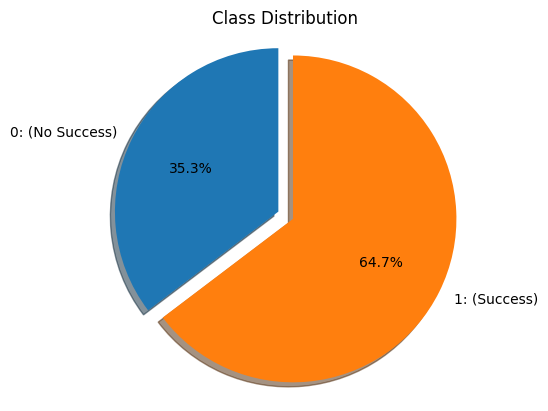

In [45]:
#we are plotting our data distribution to see if data is balanced or not
print(f"""Class distribution:
    Class 0 (No Success): {train_data[train_data['labels']==0].count()[0]}
    Class 1 (Success): {train_data[train_data['labels']==1].count()[0]}""")
labels = "0: (No Success)", "1: (Success)"
total = len(train_data)
no_success= train_data[train_data['labels']==0].count()[0]
success = train_data[train_data['labels']==1].count()[0]
sizes = [no_success/total, success/total]
explode = (0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Class Distribution")
plt.show()

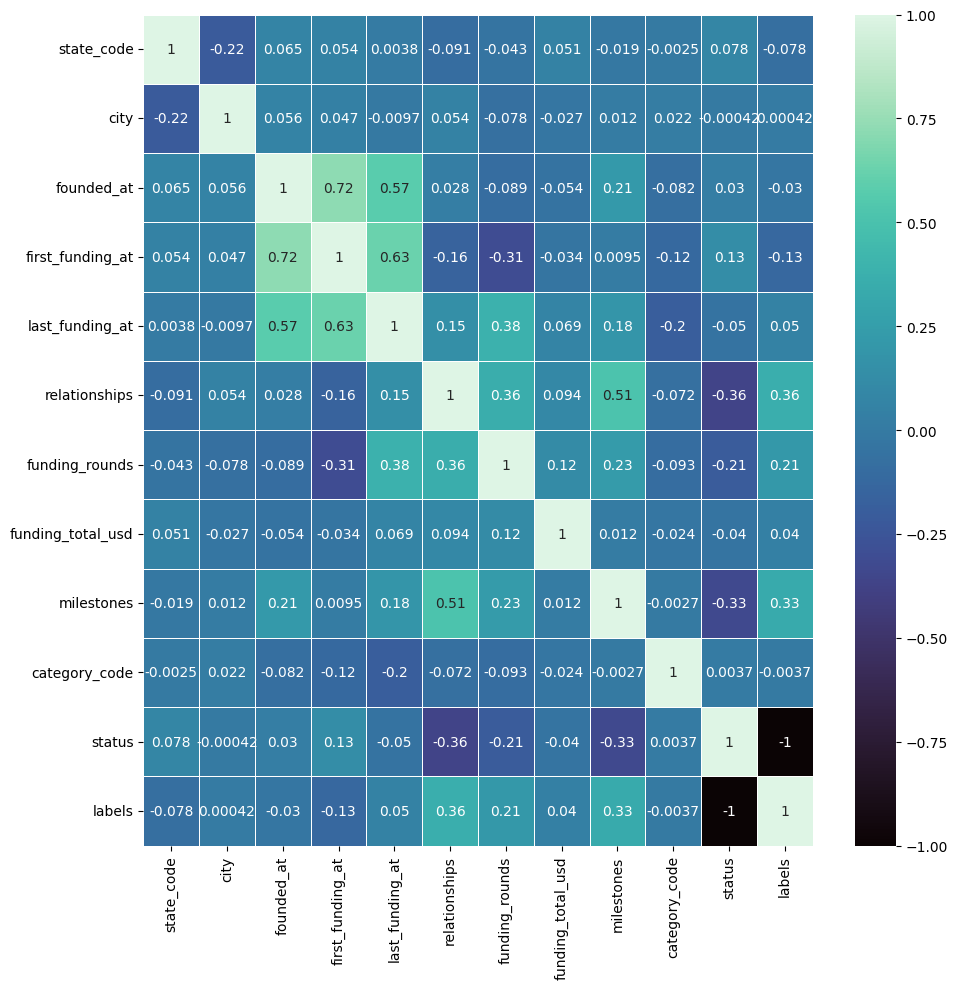

In [46]:
# We plot the heatmap in order to see the corralations between variables
correlation = train_data.corr()

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(correlation, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

In [47]:
final_columns =['state_code', 'city', 'founded_at', 'first_funding_at',
                'relationships', 'funding_rounds', 'funding_total_usd', 
                'milestones', 'category_code', 'labels']

train_data = train_data[final_columns]


In [52]:
scaler = StandardScaler()

X = train_data.drop('labels', axis=1)
y = train_data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBClassifier(random_state=123)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
base_accuracy = accuracy_score(y_test, y_pred)
base_accuracy

0.7891891891891892

In [55]:
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 44  27]
 [ 12 102]]
              precision    recall  f1-score   support

           0       0.79      0.62      0.69        71
           1       0.79      0.89      0.84       114

    accuracy                           0.79       185
   macro avg       0.79      0.76      0.77       185
weighted avg       0.79      0.79      0.78       185

